<a href="https://www.nvidia.com/dli"> <img src="images/DLI_Header.png" alt="Header" style="width: 400px;"/> </a>

# Enhancing Data Science Outcomes With Efficient Workflow #

## 03 - Model Tuning ##
This lab covers the machine learning model development step of the data science workflow. Model development involves model building, evaluation, fine-tuning, model selection, and model persistence. 

<p><img src='images/pipeline_overview_2.png' width=1080></p>

**Table of Contents**
<br>
In this notebook, we will perform model tuning. This notebook covers the below sections: 
1. [Feature Selection](#s3-1)
    * [Exhaustive Feature Selection](#s3-1.1)
2. [Hyperparameter Optimization](#s3-2)
    * [Multiple Model Training in Parallel](#s3-2.1)

Recall that distribution computing can help us scale data science in several dimensions: 
* When the challenge is memory bound, Dask offers the ability to work with larger datasets and thereby improving the performance and resilience of models
    * Data parallelism
* When the challenge is computing bound, GPU-accelerated machine learning algorithms can speed up computationally intensive workflows
    * Task parallelism

We will see both approaches used in this notebook. 

<p><img src='images/tip.png' width=720></p>

Because there is a cost associated with distributing work and moving data from host to GPU, performance gains from GPU-acceleration will be diminished for small datasets. 

<a name='s3-1'></a>
## Feature Selection ##
With a tabular dataset, every column can be used as a feature, but not all of them are useful or relevant. Feature selection aims to exclude features that are redundant or irrelevant without incurring much loss of information. In other words, feature selection can help select a subset of features that contribute the most when it comes to model prediction. Some advantages of feature selection: 
1. results in pipelines that run faster by reducing training and inference time
2. improves the generalization and reduces the chances of overfitting
3. results in better performing model
4. reduces model's complexity so it's easier to understand
5. avoids the [curse of dimensionality](https://en.wikipedia.org/wiki/Curse_of_dimensionality)

<a name='s3-1.1'></a>
### Exhaustive Feature Selection ###
One approach for feature selection tries to find a subset of features that yield the best performance by comparing models with different feature combinations. There are a few variations of this feature selection approach: 
* Exhaustive feature selection (EFS) - finds the subset of features by evaluating all feature combinations
* Forward feature selection (FFS) - finds the best subset of features by adding one feature that best improves the model at each iteration
* Sequential backward selection (SBS) or backward feature elimination - finds the best subset of features by removing one feature that has the least importance to the model at each iteration

We will perform exhaustive feature selection by trying all combinations of features. By shortening the training process through GPU-acceleration, we can perform many experiments. 

In [1]:
# import dependencies
import warnings
warnings.filterwarnings('ignore')

from dask.distributed import Client, wait
from dask_cuda import LocalCUDACluster

# instantiate a Client
cluster=LocalCUDACluster()
client=Client(cluster)

2023-12-18 18:25:33,272 - distributed.preloading - INFO - Creating preload: dask_cuda.initialize
2023-12-18 18:25:33,272 - distributed.preloading - INFO - Import preload module: dask_cuda.initialize
2023-12-18 18:25:33,279 - distributed.preloading - INFO - Creating preload: dask_cuda.initialize
2023-12-18 18:25:33,279 - distributed.preloading - INFO - Import preload module: dask_cuda.initialize
2023-12-18 18:25:33,311 - distributed.preloading - INFO - Creating preload: dask_cuda.initialize
2023-12-18 18:25:33,311 - distributed.preloading - INFO - Import preload module: dask_cuda.initialize
2023-12-18 18:25:33,321 - distributed.preloading - INFO - Creating preload: dask_cuda.initialize
2023-12-18 18:25:33,321 - distributed.preloading - INFO - Import preload module: dask_cuda.initialize


In [2]:
# get the machine's external IP address
from requests import get

ip=get('https://api.ipify.org').content.decode('utf8')

print(f'Dask dashboard (status) is accessible on http://{ip}:8787/status')
print(f'Dask dashboard (gpu) is accessible on http://{ip}:8787/gpu')

Dask dashboard (status) is accessible on http://52.91.250.178:8787/status
Dask dashboard (gpu) is accessible on http://52.91.250.178:8787/gpu


In [3]:
# import dependencies
from xgboost.dask import DaskXGBClassifier
import xgboost
from dask_ml.model_selection import train_test_split

import dask_cudf
import time
import matplotlib.pyplot as plt
import pickle
import gc

In [4]:
# initializing list
features_list=['brand', 'cat_0', 'cat_1', 'cat_2', 'cat_3', 
               'price', 'ts_hour', 'ts_minute', 'ts_weekday', 
               'brand_target_sum', 'brand_count', 'cat_0_target_sum', 
               'cat_0_count', 'cat_1_target_sum', 'cat_1_count', 
               'cat_2_target_sum', 'cat_2_count', 'cat_3_target_sum', 
               'cat_3_count', 'TE_brand_target', 'TE_cat_0_target', 
               'TE_cat_1_target', 'TE_cat_2_target', 'TE_cat_3_target', 
               'relative_price_product', 'relative_price_category']
         
include=features_list+['target']

In [5]:
# read data into Dask DataFrame
parquet_dir='processed_parquet'
ddf=dask_cudf.read_parquet(parquet_dir, columns=include)

print(f'Total of {len(ddf)} records split across {ddf.npartitions} partitions. ')

Total of 2461697 records split across 4 partitions. 


In [6]:
# split data into train and test sets
# since this data will be used multiple times, we cast it to float32 explicitly so 
# XGBoost doesn't have to do it each time
y=ddf['target'].astype('float32')
X=ddf[features_list].astype('float32')

X_train, X_test, y_train, y_test=train_test_split(X, y, random_state=42)
X_train, X_test, y_train, y_test=client.persist([X_train, X_test, y_train, y_test])
wait([X_train, X_test, y_train, y_test])

# create DaskDMatrix
dtrain=xgboost.dask.DaskDMatrix(client, X_train, y_train) 
dtest=xgboost.dask.DaskDMatrix(client, X_test, y_test) 

In [7]:
# define function to train model
def train_xgb_mgpu(columns): 
    # set train and test sets
    X_train_subset=X_train[columns]
    X_test_subset=X_test[columns]
    client.persist([X_train_subset, X_test_subset])
    wait([X_train_subset, X_test_subset])
    
    # create DaskDMatrix
    dtrain_subset=xgboost.dask.DaskDMatrix(client, X_train_subset, y_train)
    dtest_subset=xgboost.dask.DaskDMatrix(client, X_test_subset, y_test) 
    
    # set model parameter
    xgb_params={ 
        'eval_metric': ['auc'], 
        'objective': 'binary:logistic',
        'tree_method': 'gpu_hist'
    }
    
    # train the model
    model=xgboost.dask.train(client, 
                         xgb_params, 
                         dtrain=dtrain_subset,
                         evals=[(dtrain_subset, 'train'), (dtest_subset, 'valid')],
                         num_boost_round=350,
                         early_stopping_rounds=10, 
                         verbose_eval=False
    )
    return model

In [8]:
# iterative train XGBoost model with different features
# set total number of features and number of iterations
num_features=len(features_list)
iter_num=sum([n for n in range(num_features+1)])

remaining_feat=features_list
best_features={}
count=0
current_best_score=0
early_stopping_count=0

# model training
start=time.time()

while len(remaining_feat)>0 and early_stopping_count<=5:
    
    scores=[]
    for feat in remaining_feat: 
        training_feat=list(best_features.keys())+[feat]
        print(f'{round(count/iter_num*100, 2)}% complete | Training {training_feat}.', end='\r')
        
        model=train_xgb_mgpu(training_feat)
        count+=1
        
        accuracy_score=model['booster'].best_score
        scores.append(accuracy_score)

    best_score=max(scores)
    best_feat=remaining_feat[scores.index(best_score)]
    best_features[best_feat]=best_score

    remaining_feat=list(set(features_list)-set(best_features.keys()))
    
    if best_score>current_best_score: 
        current_best_score=best_score
    else: 
        early_stopping_count+=1

elapsed_time=time.time()-start
print(f'Training {count} models took {round(elapsed_time/60, 2)} minutes. ')

[18:25:58] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:25:58] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:25:58] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:25:58] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:25:59] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:25:59] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:25:59] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:25:59] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:26:00] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:26:00] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:26:00] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:26:00] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:26:00] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:26:00] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:26:00] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:26:00] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:26:01] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:26:01] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:26:01] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:26:01] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:26:01] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:26:01] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:26:01] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:26:01] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:26:02] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:26:02] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:26:02] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:26:02] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:26:02] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:26:02] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:26:02] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:26:02] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:26:03] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:26:03] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:26:03] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:26:03] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:26:03] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:26:03] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:26:03] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:26:03] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:26:03] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:26:03] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:26:03] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:26:03] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:26:04] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:26:04] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:26:04] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:26:04] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:26:04] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:26:04] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:26:04] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:26:04] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:26:05] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:26:05] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:26:05] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:26:05] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:26:05] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:26:05] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:26:05] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:26:05] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:26:06] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:26:06] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:26:06] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:26:06] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:26:06] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:26:06] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:26:06] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:26:06] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:26:07] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:26:07] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:26:07] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:26:07] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:26:07] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:26:07] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:26:07] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:26:07] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:26:07] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:26:07] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:26:07] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:26:07] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:26:08] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:26:08] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:26:08] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:26:08] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:26:08] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:26:08] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:26:08] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:26:08] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:26:09] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:26:09] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:26:09] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:26:09] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:26:09] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:26:09] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:26:09] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:26:09] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:26:09] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:26:09] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:26:09] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:26:09] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:26:10] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:26:10] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:26:10] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:26:10] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:26:11] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:26:11] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:26:11] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:26:11] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:26:12] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:26:12] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:26:12] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:26:12] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:26:12] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:26:12] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:26:12] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:26:12] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:26:13] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:26:13] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:26:13] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:26:13] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:26:13] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:26:13] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:26:13] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:26:13] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:26:14] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:26:14] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:26:14] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:26:14] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:26:14] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:26:14] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:26:14] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:26:14] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:26:15] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:26:15] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:26:15] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:26:15] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:26:16] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:26:16] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:26:16] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:26:16] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:26:16] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:26:16] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:26:16] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:26:16] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:26:17] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:26:17] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:26:17] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:26:17] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:26:18] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:26:18] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:26:18] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:26:18] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:26:19] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:26:19] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:26:19] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:26:19] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:26:20] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:26:20] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:26:20] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:26:20] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:26:20] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:26:20] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:26:20] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:26:20] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:26:21] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:26:21] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:26:21] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:26:21] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:26:22] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:26:22] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:26:22] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:26:22] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:26:22] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:26:22] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:26:22] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:26:22] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:26:23] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:26:23] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:26:23] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:26:23] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:26:23] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:26:23] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:26:23] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:26:23] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:26:24] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:26:24] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:26:24] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:26:24] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:26:25] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:26:25] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:26:25] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:26:25] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:26:26] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:26:26] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:26:26] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:26:26] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:26:26] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:26:26] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:26:26] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:26:26] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:26:26] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:26:26] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:26:26] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:26:26] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:26:28] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:26:28] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:26:28] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:26:28] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:26:29] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:26:29] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:26:29] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:26:29] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:26:31] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:26:31] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:26:31] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:26:31] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:26:33] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:26:33] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:26:33] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:26:33] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:26:35] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:26:35] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:26:35] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:26:35] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:26:36] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:26:36] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:26:36] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:26:36] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:26:38] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:26:38] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:26:38] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:26:38] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:26:40] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:26:40] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:26:40] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:26:40] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:26:42] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:26:42] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:26:42] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:26:42] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:26:43] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:26:43] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:26:43] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:26:43] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:26:44] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:26:44] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:26:44] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:26:44] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:26:45] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:26:45] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:26:45] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:26:45] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:26:48] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:26:48] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:26:48] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:26:48] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:26:49] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:26:49] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:26:49] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:26:49] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:26:50] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:26:50] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:26:50] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:26:50] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:26:53] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:26:53] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:26:53] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:26:53] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:26:55] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:26:55] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:26:55] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:26:55] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:26:56] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:26:56] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:26:56] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:26:56] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:26:58] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:26:58] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:26:58] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:26:58] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:27:00] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:27:00] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:27:00] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:27:00] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:27:02] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:27:02] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:27:02] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:27:02] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:27:04] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:27:04] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:27:04] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:27:04] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:27:06] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:27:06] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:27:06] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:27:06] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:27:08] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:27:08] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:27:08] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:27:08] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:27:09] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:27:09] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:27:09] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:27:09] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:27:12] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:27:12] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:27:12] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:27:12] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:27:14] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:27:14] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:27:14] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:27:14] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:27:16] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:27:16] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:27:16] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:27:16] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:27:18] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:27:18] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:27:18] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:27:18] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:27:21] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:27:21] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:27:21] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:27:21] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:27:23] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:27:23] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:27:23] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:27:23] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:27:25] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:27:25] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:27:25] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:27:25] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:27:27] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:27:27] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:27:27] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:27:27] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:27:30] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:27:30] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:27:30] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:27:30] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:27:32] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:27:32] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:27:32] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:27:32] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:27:34] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:27:34] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:27:34] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:27:34] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:27:36] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:27:36] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:27:36] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:27:36] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:27:38] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:27:38] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:27:38] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:27:38] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:27:41] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:27:41] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:27:41] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:27:41] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:27:43] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:27:43] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:27:43] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:27:43] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:27:45] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:27:45] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:27:45] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:27:45] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:27:47] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:27:47] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:27:47] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:27:47] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:27:49] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:27:49] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:27:49] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:27:49] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:27:51] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:27:51] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:27:51] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:27:51] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:27:54] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:27:54] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:27:54] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:27:54] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:27:56] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:27:56] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:27:56] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:27:56] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:27:58] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:27:58] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:27:58] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:27:58] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:28:00] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:28:00] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:28:00] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:28:00] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:28:03] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:28:03] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:28:03] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:28:03] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:28:05] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:28:05] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:28:05] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:28:05] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:28:07] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:28:07] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:28:07] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:28:07] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:28:10] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:28:10] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:28:10] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:28:10] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:28:12] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:28:12] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:28:12] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:28:12] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:28:14] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:28:14] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:28:14] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:28:14] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:28:17] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:28:17] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:28:17] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:28:17] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:28:19] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:28:19] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:28:19] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:28:19] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:28:21] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:28:21] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:28:21] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:28:21] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:28:24] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:28:24] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:28:24] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:28:24] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:28:26] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:28:26] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:28:26] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:28:26] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:28:28] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:28:28] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:28:28] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:28:28] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:28:30] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:28:30] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:28:30] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:28:30] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:28:32] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:28:32] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:28:32] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:28:32] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:28:35] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:28:35] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:28:35] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:28:35] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:28:37] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:28:37] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:28:37] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:28:37] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:28:39] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:28:39] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:28:39] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:28:39] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:28:41] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:28:41] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:28:41] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:28:41] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:28:44] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:28:44] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:28:44] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:28:44] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:28:46] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:28:46] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:28:46] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:28:46] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:28:48] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:28:48] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:28:48] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:28:48] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:28:51] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:28:51] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:28:51] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:28:51] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:28:53] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:28:53] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:28:53] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:28:53] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:28:56] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:28:56] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:28:56] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:28:56] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:28:58] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:28:58] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:28:58] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:28:58] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:29:00] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:29:00] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:29:00] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:29:00] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:29:03] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:29:03] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:29:03] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:29:03] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:29:05] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:29:05] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:29:05] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:29:05] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:29:07] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:29:07] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:29:07] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:29:07] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:29:10] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:29:10] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:29:10] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:29:10] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:29:12] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:29:12] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:29:12] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:29:12] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:29:14] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:29:14] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:29:14] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:29:14] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:29:17] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:29:17] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:29:17] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:29:17] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:29:19] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:29:19] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:29:19] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:29:19] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:29:21] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:29:21] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:29:21] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:29:21] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:29:24] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:29:24] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:29:24] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:29:24] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:29:26] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:29:26] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:29:26] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:29:26] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:29:29] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:29:29] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:29:29] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:29:29] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:29:31] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:29:31] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:29:31] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:29:31] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:29:33] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:29:33] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:29:33] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:29:33] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:29:36] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:29:36] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:29:36] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:29:36] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:29:38] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:29:38] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:29:38] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:29:38] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:29:40] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:29:40] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:29:40] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:29:40] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:29:43] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:29:43] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:29:43] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:29:43] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:29:45] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:29:45] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:29:45] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:29:45] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:29:48] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:29:48] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:29:48] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:29:48] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:29:50] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:29:50] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:29:50] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:29:50] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:29:52] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:29:52] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:29:52] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:29:52] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:29:54] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:29:54] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:29:54] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:29:54] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:29:57] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:29:57] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:29:57] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:29:57] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:29:59] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:29:59] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:29:59] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:29:59] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:30:02] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:30:02] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:30:02] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:30:02] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:30:04] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:30:04] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:30:04] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:30:04] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:30:06] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:30:06] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:30:06] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:30:06] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:30:09] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:30:09] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:30:09] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:30:09] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:30:11] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:30:11] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:30:11] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:30:11] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:30:14] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:30:14] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:30:14] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:30:14] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:30:16] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:30:16] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:30:16] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:30:16] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:30:18] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:30:18] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:30:18] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:30:18] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:30:21] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:30:21] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:30:21] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:30:21] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:30:23] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:30:23] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:30:23] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:30:23] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:30:26] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:30:26] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:30:26] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:30:26] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:30:28] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:30:28] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:30:28] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:30:28] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:30:30] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:30:30] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:30:30] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:30:30] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:30:33] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:30:33] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:30:33] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:30:33] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:30:35] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:30:35] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:30:35] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:30:35] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:30:38] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:30:38] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:30:38] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:30:38] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:30:40] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:30:40] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:30:40] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:30:40] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:30:43] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:30:43] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:30:43] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:30:43] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:30:45] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:30:45] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:30:45] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:30:45] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:30:48] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:30:48] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:30:48] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:30:48] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:30:50] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:30:50] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:30:50] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:30:50] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:30:53] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:30:53] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:30:53] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:30:53] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:30:55] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:30:55] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:30:55] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:30:55] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:30:58] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:30:58] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:30:58] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:30:58] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:31:00] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:31:00] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:31:00] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:31:00] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:31:03] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:31:03] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:31:03] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:31:03] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:31:05] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:31:05] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:31:05] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:31:05] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:31:08] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:31:08] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:31:08] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:31:08] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:31:10] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:31:10] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:31:10] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:31:10] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:31:12] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:31:12] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:31:12] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:31:12] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:31:15] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:31:15] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:31:15] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:31:15] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:31:17] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:31:17] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:31:17] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:31:17] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:31:20] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:31:20] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:31:20] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:31:20] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:31:22] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:31:22] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:31:22] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:31:22] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:31:25] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:31:25] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:31:25] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:31:25] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:31:27] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:31:27] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:31:27] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:31:27] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:31:30] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:31:30] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:31:30] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:31:30] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:31:32] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:31:32] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:31:32] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:31:32] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:31:35] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:31:35] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:31:35] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:31:35] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:31:38] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:31:38] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:31:38] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:31:38] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:31:40] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:31:40] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:31:40] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:31:40] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:31:43] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:31:43] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:31:43] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:31:43] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:31:45] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:31:45] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:31:45] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:31:45] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:31:48] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:31:48] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:31:48] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:31:48] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:31:50] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:31:50] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:31:50] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:31:50] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:31:53] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:31:53] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:31:53] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:31:53] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:31:55] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:31:55] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:31:55] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:31:55] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:31:58] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:31:58] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:31:58] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:31:58] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:32:00] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:32:00] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:32:00] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:32:00] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:32:03] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:32:03] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:32:03] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:32:03] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:32:05] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:32:05] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:32:05] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:32:05] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:32:08] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:32:08] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:32:08] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:32:08] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:32:10] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:32:10] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:32:10] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:32:10] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:32:13] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:32:13] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:32:13] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:32:13] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:32:15] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:32:15] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:32:15] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:32:15] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:32:18] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:32:18] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:32:18] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:32:18] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:32:21] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:32:21] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:32:21] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:32:21] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:32:23] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:32:23] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:32:23] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:32:23] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:32:26] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:32:26] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:32:26] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:32:26] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:32:28] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:32:28] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:32:28] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:32:28] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:32:31] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:32:31] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:32:31] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:32:31] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:32:33] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:32:33] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:32:33] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:32:33] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:32:36] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:32:36] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:32:36] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:32:36] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:32:38] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:32:38] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:32:38] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:32:38] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:32:41] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:32:41] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:32:41] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:32:41] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:32:43] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:32:43] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:32:43] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:32:43] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:32:46] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:32:46] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:32:46] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:32:46] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:32:49] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:32:49] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:32:49] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:32:49] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:32:51] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:32:51] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:32:51] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:32:51] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:32:54] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:32:54] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:32:54] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:32:54] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:32:56] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:32:56] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:32:56] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:32:56] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:32:59] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:32:59] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:32:59] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:32:59] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:33:02] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:33:02] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:33:02] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:33:02] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:33:04] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:33:04] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:33:04] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:33:04] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:33:07] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:33:07] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:33:07] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:33:07] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:33:09] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:33:09] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:33:09] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:33:09] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:33:12] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:33:12] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:33:12] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:33:12] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:33:14] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:33:14] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:33:14] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:33:14] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:33:17] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:33:17] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:33:17] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:33:17] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:33:20] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:33:20] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:33:20] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:33:20] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:33:22] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:33:22] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:33:22] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:33:22] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:33:25] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:33:25] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:33:25] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:33:25] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:33:28] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:33:28] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:33:28] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:33:28] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:33:30] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:33:30] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:33:30] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:33:30] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:33:33] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:33:33] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:33:33] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:33:33] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:33:35] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:33:35] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:33:35] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:33:35] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:33:38] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:33:38] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:33:38] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:33:38] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:33:41] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:33:41] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:33:41] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:33:41] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:33:43] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:33:43] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:33:43] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:33:43] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:33:46] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:33:46] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:33:46] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:33:46] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:33:48] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:33:48] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:33:48] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:33:48] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:33:51] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:33:51] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:33:51] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:33:51] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:33:54] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:33:54] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:33:54] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:33:54] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:33:56] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:33:56] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:33:56] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:33:56] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:33:59] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:33:59] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:33:59] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:33:59] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:34:01] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:34:01] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:34:01] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:34:01] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:34:04] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:34:04] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:34:04] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:34:04] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:34:07] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:34:07] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:34:07] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:34:07] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:34:09] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:34:09] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:34:09] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:34:09] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:34:12] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:34:12] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:34:12] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:34:12] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:34:15] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:34:15] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:34:15] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:34:15] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:34:17] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:34:17] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:34:17] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:34:17] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:34:20] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:34:20] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:34:20] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:34:20] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:34:23] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:34:23] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:34:23] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:34:23] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:34:25] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:34:25] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:34:25] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:34:25] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:34:28] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:34:28] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:34:28] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:34:28] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:34:31] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:34:31] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:34:31] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:34:31] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:34:33] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:34:33] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:34:33] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:34:33] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:34:36] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:34:36] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:34:36] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:34:36] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:34:39] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:34:39] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:34:39] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:34:39] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:34:41] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:34:41] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:34:41] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:34:41] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:34:44] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:34:44] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:34:44] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:34:44] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:34:47] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:34:47] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:34:47] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:34:47] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:34:49] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:34:49] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:34:49] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:34:49] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:34:52] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:34:52] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:34:52] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:34:52] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:34:55] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:34:55] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:34:55] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:34:55] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:34:57] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:34:57] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:34:57] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:34:57] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:35:00] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:35:00] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:35:00] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:35:00] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:35:03] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:35:03] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:35:03] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:35:03] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:35:05] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:35:05] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:35:05] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:35:05] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:35:08] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:35:08] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:35:08] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:35:08] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:35:11] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:35:11] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:35:11] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:35:11] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:35:13] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:35:13] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:35:13] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:35:13] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:35:16] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:35:16] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:35:16] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:35:16] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:35:19] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:35:19] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:35:19] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:35:19] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:35:21] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:35:21] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:35:21] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:35:21] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:35:24] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:35:24] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:35:24] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:35:24] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:35:27] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:35:27] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:35:27] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:35:27] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:35:30] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:35:30] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:35:30] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:35:30] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:35:32] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:35:32] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:35:32] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:35:32] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:35:35] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:35:35] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:35:35] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:35:35] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:35:38] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:35:38] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:35:38] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:35:38] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:35:41] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:35:41] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:35:41] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:35:41] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:35:44] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:35:44] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:35:44] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:35:44] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:35:46] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:35:46] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:35:46] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:35:46] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:35:49] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:35:49] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:35:49] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:35:49] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:35:52] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:35:52] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:35:52] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:35:52] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:35:55] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:35:55] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:35:55] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:35:55] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:35:57] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:35:57] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:35:57] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:35:57] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:36:00] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:36:00] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:36:00] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:36:00] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:36:03] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:36:03] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:36:03] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:36:03] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:36:06] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:36:06] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:36:06] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:36:06] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:36:08] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:36:08] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:36:08] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:36:08] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:36:11] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:36:11] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:36:11] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:36:11] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:36:14] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:36:14] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:36:14] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:36:14] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


[18:36:17] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:36:17] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:36:17] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:36:17] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3


Training 296 models took 10.36 minutes. 


Best validation score is: 0.6323556495746291


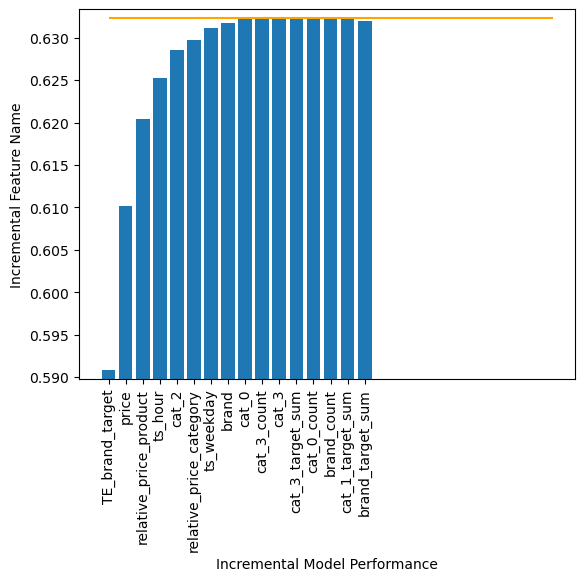

In [9]:
# print best training score
print(f'Best validation score is: {max(best_features.values())}')

# plot model performances
plt.bar(x=best_features.keys(), height=best_features.values())
plt.xticks(rotation=90)
plt.ylim([min(best_features.values())-0.001, max(best_features.values())+0.001])
plt.hlines(max(best_features.values()), 0, len(features_list), color='orange')
plt.ylabel('Incremental Feature Name')
plt.xlabel('Incremental Model Performance')
plt.show()

In [10]:
# save list of selected features
features=list(best_features.keys())
scores=list(best_features.values())

# get list of selected features
selected_features=features[:scores.index(max(scores))+1]
print(f'Selected features are: {selected_features}')

with open('selected_features.pkl', 'wb') as f: 
    pickle.dump(selected_features, f)

Selected features are: ['TE_brand_target', 'price', 'relative_price_product', 'ts_hour', 'cat_2', 'relative_price_category', 'ts_weekday', 'brand', 'cat_0', 'cat_3_count']


Based on the numerous iterative training, we see that the model actually starts to perform worse with additional features. Going forward, we should train a model using only the features that are beneficial to the model. Furthermore, we should adjust the data processing pipeline such that it doesn't create the noisy features. 

In [11]:
del model, X_train, X_test, y_train, y_test, X, y, ddf
gc.collect()

7744

<a name='s3-2'></a>
## Hyperparameter Optimization ##
Hyperparameters refer to the parameters used during the model training process but are not "learned" during the training. While finding the optimal hyperparameters can be computationally costly, it can improve model performance. `Dask-ML` and `cuML` can be used to improve the efficiency of hyperparameter optimization by leveraging GPU-acceleration and distributed schedulers. 

We will use `dask_ml.model_selection.GridSearchCV`[[doc]](https://ml.dask.org/modules/generated/dask_ml.model_selection.GridSearchCV.html) to performs an exhaustive search over specific parameter values for a model. `GridSearchCV` requires an `estimator`, which an object of this type is instantiated for each parameter search. It uses a 3-fold cross-validation by default. 

When using `dask_ml.model_selection.GridSearchCV`, we have to use `xgboost.XGBClassifier` as the estimator. The GridSearchCV is designed to extend single node algorithms, like estimators in scikit-learn that accepts numpy arrays. It runs the estimators with different hyperparameter on each worker's local data, instead of running them on the distributed data structure. The GridSearchCV will train variations of the estimator in parallel. It works when datasets fit in memory on the individual workers. Since we've performed feature selection, we only need to load a subset of features, thereby reducing the memory burden. 

<p><img src='images/tip.png' width=720></p>

We cannot use `dask_ml.model_selection.GridSearchCV` with `xgboost.dask.DaskXGBClassifier`. For use cases when the dataset is too large to fit into GPU memory, Dask is used to distribute data into partitions and `xgboost.dask.DaskXGBClassifier` is used to train on Dask collections and avoid loading all the data into memory at once. However, the estimators that `dask_ml` supports cannot handle partial training. 

In [12]:
# import dependencies
import xgboost
from dask_ml.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

import dask.dataframe as dd
import matplotlib.pyplot as plt
import numpy as np
import dask_cudf
import time
import pandas as pd
import pickle

We start by loading the data. We will use the best features we found from the previous exercise. 

In [13]:
# initializing list
with open('selected_features.pkl', 'rb') as f: 
    features_list=pickle.load(f)
         
include=features_list+['target']

In [14]:
# load data
parquet_dir='processed_parquet'
ddf=dd.read_parquet(parquet_dir, columns=include)
df=ddf.compute()

print(f'Total of {len(df)} records. ')

Total of 2461697 records. 


In [15]:
# under the hood, XGBoost converts floats to `float32`.
y=df['target'].astype('float32')
X=df[features_list].astype('float32')

X_train, X_test, y_train, y_test=train_test_split(X, y, random_state=42)

In [16]:
# define estimator
xgb_params={ 
    'n_estimators': 350, 
    'eval_metric': ['auc'], 
    'objective': 'binary:logistic',
    'tree_method': 'gpu_hist', 
    'early_stopping_rounds': 10
    # 'n_jobs': 4
}

xgb_gpu=xgboost.XGBClassifier(**xgb_params, n_jobs=4)

We will want to define a `param_grid` to include possible parameter setting we want to experiment. The performance of each experimentation is cross validated on a holdout set. By default, `dask_ml.model_selection.GridSearchCV` uses a 3-fold cross validation but can be changed using the `cv` parameter. 

In [17]:
param_grid={
    'max_depth': range(5, 8), # default is 6
    'learning_rate': np.arange(0.1, 0.31, 0.2), # default is 0.3
    'subsample': np.arange(0.6, 1.01, 0.2), # default is 1
    'min_child_weight': [1, 10], # default is 1
    'colsample_bytree': np.arange(0.9, 1.01, 0.1) # default is 1
} 

`dask_ml.model_selection.GridSearchCV` requires a `scheduler`, which specifies the Dask scheduler to use. If not set, the default scheduler will be used, which may not use the GPU workers. When fitting, we will pass `X`, and `y`, which reference the DataFrame that we loaded into memory with  `dask.dataframe` and `.compute()`. 

In [18]:
grid_search = GridSearchCV(
    xgb_gpu,
    param_grid=param_grid, 
    # n_jobs=4
    scheduler=client
)

start = time.time()
grid_search.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)
elapsed_time=time.time()-start

print(f'Training took {round(elapsed_time/60, 2)} minutes. ')

Training took 4.44 minutes. 


`GridSearchCV` provides the search results via the `.cv_results_` property. Since the output is fairly small, we can use Pandas to visualize the search results in a pandas DataFrame. 

In [19]:
# load search results in pandas DataFrame
pd.DataFrame(grid_search.cv_results_).head()

params  mean_fit_time  \
0  {'colsample_bytree': 0.9, 'learning_rate': 0.1...       3.297302   
1  {'colsample_bytree': 0.9, 'learning_rate': 0.1...       3.318754   
2  {'colsample_bytree': 0.9, 'learning_rate': 0.1...       3.196431   
3  {'colsample_bytree': 0.9, 'learning_rate': 0.1...       3.337676   
4  {'colsample_bytree': 0.9, 'learning_rate': 0.1...       3.325014   

   std_fit_time  mean_score_time  std_score_time  split0_test_score  \
0      0.015074         0.955551        0.004704           0.609076   
1      0.025194         0.950972        0.006783           0.609893   
2      0.043480         0.950201        0.002796           0.609606   
3      0.016289         0.949386        0.002539           0.608943   
4      0.043427         0.947873        0.004405           0.609471   

   split1_test_score  split2_test_score  mean_test_score  std_test_score  \
0           0.609349           0.610118         0.609514        0.000441   
1           0.609305           0.610197         0.609799        0.000370   
2           0.609448           0.610064         0.609706        0.000261   
3           0.609346           0.610421         0.609570        0.000624   
4           0.609416           0.610038         0.609641        0.000281   

   rank_test_score param_colsample_bytree param_learning_rate param_max_depth  \
0               72                    0.9                 0.1               5   
1               65                    0.9                 0.1               5   
2               66                    0.9                 0.1               5   
3               71                    0.9                 0.1               5   
4               69                    0.9                 0.1               5   

  param_min_child_weight param_subsample  
0                      1             0.6  
1                      1             0.8  
2                      1             1.0  
3                     10             0.6  
4                     10             0.8

Once the search is complete, we can use the `.best_estimator_` property to get the estimator which gave the highest score. We can also get the parameter setting that gave the best results with the `.best_params_` property. Knowing the optimal hyperparameters to use, we will use them to retrain the model. 

In [20]:
# print best parameters
best_params=grid_search.best_params_
print(best_params)

{'colsample_bytree': 1.0, 'learning_rate': 0.30000000000000004, 'max_depth': 7, 'min_child_weight': 1, 'subsample': 1.0}


In [21]:
# import dependencies
from dask_ml.model_selection import train_test_split
from dask_ml.metrics import accuracy_score

In [22]:
# load data
parquet_dir='processed_parquet'
ddf=dask_cudf.read_parquet(parquet_dir, columns=include)

print(f'Total of {len(ddf)} records split across {ddf.npartitions} partitions. ')

Total of 2461697 records split across 4 partitions. 


In [23]:
# split data into train and test sets
y=ddf['target'].astype('float32')
X=ddf[features_list].astype('float32')

X_train, X_test, y_train, y_test=train_test_split(X, y, random_state=42)
X_train, X_test, y_train, y_test=client.persist([X_train, X_test, y_train, y_test])
wait([X_train, X_test, y_train, y_test])

DoneAndNotDoneFutures(done={<Future: finished, type: cudf.core.series.Series, key: ('split-1-375ff10de9a327cb4b8e7b676fb35ee1', 1)>, <Future: finished, type: cudf.core.series.Series, key: ('split-1-375ff10de9a327cb4b8e7b676fb35ee1', 3)>, <Future: finished, type: cudf.core.dataframe.DataFrame, key: ('split-1-0349297dcd5b14f298373ae17e76d793', 0)>, <Future: finished, type: cudf.core.dataframe.DataFrame, key: ('split-0-0349297dcd5b14f298373ae17e76d793', 2)>, <Future: finished, type: cudf.core.series.Series, key: ('split-0-375ff10de9a327cb4b8e7b676fb35ee1', 0)>, <Future: finished, type: cudf.core.series.Series, key: ('split-0-375ff10de9a327cb4b8e7b676fb35ee1', 3)>, <Future: finished, type: cudf.core.series.Series, key: ('split-0-375ff10de9a327cb4b8e7b676fb35ee1', 1)>, <Future: finished, type: cudf.core.dataframe.DataFrame, key: ('split-1-0349297dcd5b14f298373ae17e76d793', 1)>, <Future: finished, type: cudf.core.dataframe.DataFrame, key: ('split-1-0349297dcd5b14f298373ae17e76d793', 2)>, <Fu

In [27]:
# create DaskDMatrix
dtrain=xgboost.dask.DaskDMatrix(client, X_train, y_train)
dtest=xgboost.dask.DaskDMatrix(client, X_test, y_test)

In [28]:
# retrain optimized model
xgb_params.update(best_params)

# train the model
xgb_dask_clf=xgboost.dask.train(client, 
                     xgb_params, 
                     dtrain=dtrain,
                     evals=[(dtrain, 'train'), (dtest, 'valid')],
                     num_boost_round=350,
                     early_stopping_rounds=10
)

[18:45:48] task [xgboost.dask-0]:tcp://127.0.0.1:35043 got new rank 0
[18:45:48] task [xgboost.dask-1]:tcp://127.0.0.1:40431 got new rank 1
[18:45:48] task [xgboost.dask-2]:tcp://127.0.0.1:34239 got new rank 2
[18:45:48] task [xgboost.dask-3]:tcp://127.0.0.1:33521 got new rank 3
[18:45:48] WARNING: /var/lib/jenkins/workspace/rapidsai/conda/xgboost/xgboost-conda-build/CUDA/11.5/PYTHON/3.9/conda-bld-workspace/work/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "n_estimators" } are not used.

[18:45:48] WARNING: /var/lib/jenkins/workspace/rapidsai/conda/xgboost/xgboost-conda-build/CUDA/11.5/PYTHON/3.9/conda-bld-workspace/work/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "n_estimators" } are not used.

[18:45:48] WARNING: /var/lib/jenkins/workspace/rapidsai/conda/xgboost/xgboost-conda-build/CUDA/11.5/PYTHON/3.9/conda-bld-workspace/work/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "n_estimators" } are not used.

[18:45:48] WARNING: /var/lib/jenkins

[0]	train-auc:0.60819	valid-auc:0.60660
[1]	train-auc:0.61149	valid-auc:0.60972
[2]	train-auc:0.61212	valid-auc:0.61023
[3]	train-auc:0.61321	valid-auc:0.61111
[4]	train-auc:0.61399	valid-auc:0.61186
[5]	train-auc:0.61474	valid-auc:0.61239
[6]	train-auc:0.61561	valid-auc:0.61318
[7]	train-auc:0.61620	valid-auc:0.61349
[8]	train-auc:0.61686	valid-auc:0.61395
[9]	train-auc:0.61771	valid-auc:0.61475
[10]	train-auc:0.61809	valid-auc:0.61490
[11]	train-auc:0.61860	valid-auc:0.61508
[12]	train-auc:0.61912	valid-auc:0.61549
[13]	train-auc:0.61957	valid-auc:0.61564
[14]	train-auc:0.61971	valid-auc:0.61569
[15]	train-auc:0.62034	valid-auc:0.61622
[16]	train-auc:0.62096	valid-auc:0.61674
[17]	train-auc:0.62129	valid-auc:0.61695
[18]	train-auc:0.62187	valid-auc:0.61740
[19]	train-auc:0.62258	valid-auc:0.61800
[20]	train-auc:0.62295	valid-auc:0.61819
[21]	train-auc:0.62344	valid-auc:0.61848
[22]	train-auc:0.62397	valid-auc:0.61898
[23]	train-auc:0.62444	valid-auc:0.61932
[24]	train-auc:0.62463	val

In [29]:
# predict
start=time.time()
prediction_test=xgboost.dask.predict(client, xgb_dask_clf, dtest)
elapsed_time=time.time()-start

print(f'Accuracy score for test set: {round(float(accuracy_score(y_test, prediction_test>0.5))*100, 2)}%')

throughput=round(len(X_test)/elapsed_time, 2)
print(f'Throughput is: {throughput} per seconds. ')

Accuracy score for test set: 61.67%
Throughput is: 1325688.49 per seconds. 


/opt/conda/envs/rapids/lib/python3.9/site-packages/cudf/core/single_column_frame.py:345: FutureWarning: Binary operations between host objects such as <class 'numpy.ndarray'> and <class 'cudf.core.series.Series'> are deprecated and will be removed in a future release. Please convert it to a cudf object before performing the operation.
  warnings.warn(
/opt/conda/envs/rapids/lib/python3.9/site-packages/cudf/core/single_column_frame.py:345: FutureWarning: Binary operations between host objects such as <class 'numpy.ndarray'> and <class 'cudf.core.series.Series'> are deprecated and will be removed in a future release. Please convert it to a cudf object before performing the operation.
  warnings.warn(
/opt/conda/envs/rapids/lib/python3.9/site-packages/cudf/core/single_column_frame.py:345: FutureWarning: Binary operations between host objects such as <class 'numpy.ndarray'> and <class 'cudf.core.series.Series'> are deprecated and will be removed in a future release. Please convert it to a 

<p><img src='images/tip.png' width=720></p>

It is recommended to use a grid-search method to find the optimal hyperparameters of a model that results in the most accurate predictions. To avoid overfitting, we can increase training data sample size that introduces more patterns, reduce the number of features to reduce complexity, or introduce data regularization. To avoid underfitting, we can introduce more complexity by adding more features, although this approach may require more data to fit. 

<a href="https://www.nvidia.com/dli"> <img src="images/DLI_Header.png" alt="Header" style="width: 400px;"/> </a>